<a href="https://colab.research.google.com/github/daniilprigozhin/NLRome_Align_Tree/blob/main/Soy_CladeFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program takes a immunoprotein sequence for Soy, Maize, or Arabidopsis and returns the clade in which this protein lies in relation to known subspecies. We also return a Shannon Entropy model for analyzing highly variable portions of the protein, which can be viewed on tools like Chimera. Please use Chrome for this process to ensure results.

In [29]:
#@title Install Non-Python Dependencies
#@markdown This block may take 4-5 minutes. If it says your session crashed, do not be alarmed and continue running the next code block. This is a bug from importing one of the necessary packages onto Colab.

!pip install -q condacolab &> /dev/null
import condacolab
condacolab.install()
!conda install -c bioconda hmmer &> /dev/null
!conda install -c bioconda mafft &> /dev/null
!pip install Bio &> /dev/null
from collections import defaultdict
from Bio import SearchIO
!conda install -c bioconda epa-ng &> /dev/null
!conda install -c bioconda gappa &> /dev/null
from google.colab import files
!pip install toytree &> /dev/null

from Bio import AlignIO

✨🍰✨ Everything looks OK!


In [42]:
#@title Install Python Dependencies
!pip install -q gwpy &> /dev/null
!conda install -c bioconda hmmer &> /dev/null
!conda install -c bioconda mafft &> /dev/null
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import toytree       # a tree plotting library
import toyplot       # a general plotting library

In [63]:
#@title Select Species
Species = "Maize" #@param ["Soy", "Arabidopsis", "Maize"]

%cd /content
!rm -rf NLRome_Align_Tree
!git clone https://github.com/daniilprigozhin/NLRome_Align_Tree &> /dev/null
 
%cd NLRome_Align_Tree/
if Species == 'Soy':
  %cd Soy_NLRome
  common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')
elif Species == "Arabidopsis":
  %cd Atha_NLRome
  common = pd.read_csv("Atha_NLRome_GeneTable.txt", sep = '\t')
else:
  %cd Maize_NLRome
  common = pd.read_csv("Maize_NLRome_GeneTable.txt", sep = '\t')


clades = common[["Clade", "File"]].groupby("Clade").first()
!unzip All_Clades.zip

/content
/content/NLRome_Align_Tree
/content/NLRome_Align_Tree/Maize_NLRome
Archive:  All_Clades.zip
  inflating: All_Clades.hmm          


In [64]:
# Code used from https://github.com/sokrypton/ColabFold
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MIRKITRRFSISTDRAGFQFRPEGDDGSTSEGIVDITRWFEEIHTDQTAAQLRPEDEDGDISKRIGEIIRRFEEITGDRAALHLGQEDGERNTWSGRDSTWESRVTSHLLDESCVFGRTKEKEHVVKLVKSYSKCPGIHVLPIVGMGGIGKTTVAQMVYREVQESYDLLSWVHVPETFDLRKLAIAITESLSRQPCTYNNFSVVHDVLQQTVLNKRVFLVLDDLWNERQICWQDFLCSLKFADTMTILVTTRSKEVAQLLQTIPHFELGLLPEDHCWQLFQCYAFGHRNIHEESALVQVGRKIMEKCSCLPLAIKSIGCLLRSKMDMQTWMEISDSEFWEYSDNNEEILSALRLSFHRLPGRLKPCFLLCALYPKGEPFTKDDMIHLWTAHGYVQPSGCKTLEKVAGEYFDELNERSLIEMDTYYLVSREGHNYLKKSRVRSPVEISSGEIFDTDVSFYELHIRSLVENFHKGTTESSLPFQLFRLHDMIWDLAKSLSSCLFSAVAVDEGNLYMQNEVQHLFLWLGRGRSKQNTQRGHSELIPISKSRDLFISWINNSLGLESEPFRWRHRSTPRPSHRPQVSDFELLGLSSTALLGIALEAMIQARPDPVQDPMSSARLLAYLPENKHEYILSTQSRRSQLFKIDYLRTLILKQCTFYNIGIYTYLRALILYSCKDSGCIAAIQYLKLLRYLNIRNCDSLTGKNLNHLTQSICHLYSLEKLIVSTCWKEFSIQSCHLFSLRYLQLSVQFNDWSQHPLCHFHNLDTLCLQNCHSIAELPTGIGNLMNLRCLKLIGISEIKKLNHDSLLCQCNNNKCQLMKAIFPALMELELDSLCELQDWCKFQDPDCPKMQSITVRNCNKLRRIPYFGSVRSLMIINSALIGLQLSASNEPSQLQTLDISYCENLESLLGLENLCSLGSLYIAHCPKLFVLRQEKLLFRPQNILIDDCPGLIEWCDEQELYYHVRSYALLFFLF' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'test' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname_unhashed = jobname
jobname = add_hash(jobname, query_sequence)

%mkdir {jobname}
%cd {jobname}


with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">" + jobname_unhashed + "\n%s" % query_sequence)

/content/NLRome_Align_Tree/Maize_NLRome/test_2070a


In [65]:
#@title Create an Annotated Tree with your protein included
!hmmsearch --domtblout {jobname}.tbl.out ../All_Clades.hmm {jobname}.fasta &> /dev/null

filename = jobname + ".tbl.out"

attribs = ['bias', 'bitscore',  'evalue']

hits = defaultdict(list)
names = []

with open(filename) as handle:
    for queryresult in SearchIO.parse(handle, 'hmmsearch3-domtab'):
      #print(queryresult.id)
      #print(queryresult.accession)
      #print(queryresult.description)
      for hit in queryresult.hsps:
        names.append(queryresult.id)
        for attrib in attribs:
          hits[attrib].append(getattr(hit, attrib))

final = pd.DataFrame.from_dict(hits)
final["Clade"] = names
final.sort_values("bitscore", ascending = False)

#common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')

final_hv = final.set_index("Clade").join(common[["Clade", "HV", "File"]].groupby("Clade").agg(max), how = 'left', rsuffix = "_other").sort_values("bitscore", ascending = False)
best_afa_file = final_hv.iloc[0,:]["File"]
best_afa = "../" + best_afa_file

!mafft --add {jobname}.fasta --keeplength {best_afa} > {jobname}.updated.afa

clade_oi = common[common["File"] == best_afa_file].iloc[0,:]["Clade"]
tree_oi = best_afa[:best_afa.find("Int")] + "RAxML_bestTree." + clade_oi + ".Raxml.out"
raxml_info_oi = best_afa[:best_afa.find("Int")] + "RAxML_info." + clade_oi + ".Raxml.out"

!epa-ng --split {best_afa} {jobname}.updated.afa --tree {tree_oi} --model {raxml_info_oi}
!cut -f1 -d ' ' {best_afa} > best_afa_f.afa
!epa-ng --ref-msa best_afa_f.afa --tree {tree_oi} -q query.fasta --model {raxml_info_oi} --redo

!gappa examine graft --jplace-path ./ &> /dev/null

tree_created = True

is_hv = final_hv.iloc[0,:]["HV"] == 1

nadd = 1
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 27
done.

Constructing a UPGMA tree (efffree=0) ... 
   20 / 27
done.

Progressive alignment 1/2... 
STEP     1 / 26  f
done.

Making a distance matrix from msa.. 
    0 / 27
done.

Constructing a UPGMA tree (efffree=1) ... 
   20 / 27
done.

Progressive alignment 2/2... 
STEP     7 / 26  f
done.

disttbfast (aa) Version 7.490
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --

In [66]:
#@title View tree
directory = os.getcwd()
file_name = directory + "/epa_result.newick" 
tre = toytree.tree(file_name)
tre.draw(tip_labels_align=True);

<svg class="toyplot-canvas-Canvas" height="486.0px" id="td1602daf4a3b479fba2cc40b6f447c4d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 486.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> ZM00042AB208440_P001 ZM00040AB213700_P001 ZM00023AB205790_P001 ZM00026AB202080_P001 ZM00020AB203020_P001 ZM00038AB203290_P001 ZM00030AB201330_P001 ZM00036AB205570_P001 ZM00018AB207760_P001 ZM00019AB190200_P001 ZM00033AB212370_P001 ZM00039AB204460_P001 ZM00021AB202840_P001 ZM00037AB202220_P001 ZM00041AB208620_P001 ZM00028AB205830_P001 ZM00032AB206910_P001 ZM00027AB203620_P001 ZM00031AB207970_P001 ZM00034AB212110_P001 ZM00024AB203470_P001 ZM00022AB202710_P001 ZM00029AB207050_P001 ZM00035AB206490_P001 ZM00001EB200120_P001 test ZM00025AB207720_P001

In [67]:
#@title This block will tell you if your sequence falls within a highly variable clade.
if is_hv:
  print("Your protein belongs to a highly variable clade.")
else:
  print("Your protein is not in a highly variable clade.")


Your protein is not in a highly variable clade.


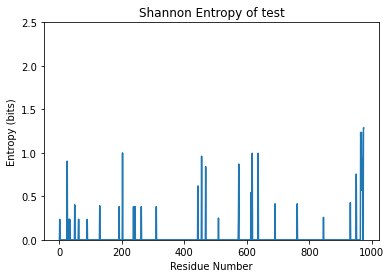

In [68]:
#@title Above ends the process of tree creation. Here we create a Shannon Entropy model (receommended for proteins in highly variable clades), and print the graphed entropy results.
def entropy(string):
    "Calculates the Shannon entropy of a string"
    string = string.replace("-","")
    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list("ARNDCQEGHILKMFPSTWYV")) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob if p > 0])

    return entropy

gene = query_sequence
cn = jobname_unhashed
file_oi = jobname + ".updated.afa"

align = AlignIO.read(file_oi, "fasta")

length = len(align[1,:])
entropies = []
for i in range(length):
  col = align[:,i]
  if col[len(align) - 1] == "-":
    continue
  entropies.append(entropy(col))

f = open(jobname+"_Chimera_Entropy.txt", "w")
f.write("attribute: shannonEntropy\n")
f.write("match mode: 1-to-1\n")
f.write("recipient: residues\n")
for i in range(1,len(entropies)+1):
  f.write("\t:")
  f.write(str(i))
  f.write("\t")
  f.write(str(entropies[i-1]))
  f.write("\n")

ylim = max(max(entropies), 2.5)

plt.ylim(0,ylim);
plt.plot(entropies);
plt.xlabel("Residue Number");
plt.ylabel("Entropy (bits)");
plt.title("Shannon Entropy of "+jobname_unhashed);
plt.savefig(jobname + "_Entropy_MaskedNG");

shannon_created = True

In [ ]:
#@title Download Results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the folder icon to the left, navigate to /content, and manually download {jobname}_results.zip.

new_folder = jobname_unhashed + "_results"
!mkdir {new_folder}
!mv {jobname}.updated.afa {new_folder}
!mv epa_result.newick {new_folder}
if shannon_created:
  %mv {jobname}_Chimera_Entropy.txt {new_folder}
  %mv {jobname}_Entropy_MaskedNG.png {new_folder}

!mv {new_folder} ../../../
%cd /content
!zip -r {new_folder}.zip {new_folder}
res = new_folder + ".zip"
files.download(res)

Sources: